# Classification Approach

## 1 Imports and Config

### 1.1 Imports

In [ ]:
!pip install scikit-allel

import allel

In [ ]:
import os
import pickle

import json
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy

from google.colab import drive

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.listdir('gdrive/MyDrive/CS4220_Data')

['real1-freebayes.vcf.gz',
 'real1-mutect2.vcf.gz',
 'real1_truth.bed',
 'real1-vardict.vcf.gz',
 'real1-varscan.vcf.gz',
 'syn1_truth.bed',
 'syn1-mutect2.vcf.gz',
 'syn1-freebayes.vcf.gz',
 'syn1-varscan.vcf.gz',
 'syn1-vardict.vcf.gz',
 'syn2_truth.bed',
 'syn2-freebayes.vcf.gz',
 'syn2-mutect2.vcf.gz',
 'syn2-vardict.vcf.gz',
 'syn2-varscan.vcf.gz',
 'syn3_truth.bed',
 'syn3-mutect2.vcf.gz',
 'syn3-freebayes.vcf.gz',
 'syn3-varscan.vcf.gz',
 'syn3-vardict.vcf.gz',
 'syn4_truth.bed',
 'syn4-mutect2.vcf.gz',
 'syn4-freebayes.vcf.gz',
 'syn4-varscan.vcf.gz',
 'syn5_truth.bed',
 'syn4-vardict.vcf.gz',
 'syn5-mutect2.vcf.gz',
 'syn5-freebayes.vcf.gz',
 'syn5-vardict.vcf.gz',
 'syn5-varscan.vcf.gz',
 'real2-mutect2.vcf.gz',
 'real2-freebayes.vcf.gz',
 'real2_truth.bed',
 'real2-varscan.vcf.gz',
 'real2-vardict.vcf.gz',
 'real3-freebayes.vcf.gz',
 'real3-varscan.vcf.gz',
 'real3-vardict.vcf.gz',
 'real3-mutect2.vcf.gz',
 'real3_test.bed',
 'data_features.pkl',
 'real1-freebayes.csv',
 're

### 1.2 Config

In [ ]:
HOME = 'gdrive/MyDrive/CS4220_Data'

In [ ]:
datasets = ['real1', 'real2', 'real3', 'syn1', 'syn2', 'syn3', 'syn4', 'syn5']
methods = ['freebayes', 'mutect2', 'varscan', 'vardict']
dfs = {}

## 2. Get data from files

Skip 2.1 and 2.2 if you already have the pickle file.

### 2.1 Load data to dataframe

In [ ]:
combined_df = None
for dataset in ['real1']:
    truth_df = pd.read_csv(HOME+'/'+dataset+'_truth.bed', delimiter='\t', header=None, names=['CHROM', 'START_POS', 'END_POS'])
    for method in [methods[3]]:
        temp_df = allel.vcf_to_dataframe(HOME+'/'+dataset+'-'+method+'.vcf.gz', fields='variants/*')
        print(f'Read {method} from {dataset}')
        combined_df = temp_df.merge(truth_df[['CHROM', 'START_POS']], how='left', left_on=['CHROM', 'POS'], right_on=['CHROM', 'START_POS'])
        combined_df['y_true'] = combined_df['START_POS'].notna().astype(int)
        combined_df['FILTER_PASS'] = combined_df['FILTER_PASS'].fillna(-1).astype(int)
        print(combined_df.head())

Read vardict from real1
  CHROM    POS           ID     REF ALT_1  ALT_2  ALT_3   QUAL    AF_1  AF_2  \
0     1  10230  rs775928745      AC     A    NaN    NaN  106.0  0.2667   NaN   
1     1  10231  rs200279319       C     A    NaN    NaN   75.0  0.1111   NaN   
2     1  10250            .  ACCCTA  CCCT    NaN    NaN   42.0  0.0556   NaN   
3     1  10583   rs58108140       G     A    NaN    NaN  122.0  0.4231   NaN   
4     1  12783   rs62635284       G     A    NaN    NaN  190.0  0.6972   NaN   

   ...  FILTER_pSTD  FILTER_q22.5  FILTER_v3 numalt  altlen_1  altlen_2  \
0  ...        False         False      False      1        -1         0   
1  ...        False         False      False      1         0         0   
2  ...        False          True       True      1        -2         0   
3  ...        False         False      False      1         0         0   
4  ...        False         False      False      1         0         0   

  altlen_3 is_snp  START_POS  y_true  
0    

In [ ]:
chroms = [str(x) for x in range(24)] + ['X', 'Y']
combined_df = combined_df[combined_df['CHROM'].isin(chroms)]

In [ ]:
combined_df['y_true'].value_counts()

0    4747298
1       1179
Name: y_true, dtype: int64

In [ ]:
features = combined_df.columns.values.tolist()
to_remove = ['CHROM', 'POS', 'ID', 'REF', 'START_POS', 'y_true']
total = len(combined_df)
for col in features:
  nas = combined_df[col].isna().sum()
  perc = nas/total
  if(perc > 0.1):
    to_remove.append(col)
print(to_remove)
for f in list(set(to_remove)):
  features.remove(f)
print(features)
print(len(features))

['CHROM', 'POS', 'ID', 'REF', 'START_POS', 'y_true', 'ALT_2', 'ALT_3', 'AF_2', 'AF_3', 'LOF', 'NMD', 'START_POS']
['ALT_1', 'QUAL', 'AF_1', 'DP', 'END', 'LSEQ', 'MSI', 'MSILEN', 'RSEQ', 'SAMPLE', 'SHIFT3', 'SOMATIC', 'SOR', 'SSF', 'STATUS', 'TYPE', 'VD', 'ANN', 'FILTER_PASS', 'FILTER_Bias', 'FILTER_Cluster0bp', 'FILTER_DIFF0.2', 'FILTER_InDelLikely', 'FILTER_InGap', 'FILTER_InIns', 'FILTER_LongAT', 'FILTER_LowAlleleDepth', 'FILTER_LowFreqQuality', 'FILTER_MAF0.05', 'FILTER_MSI12', 'FILTER_NM4.25', 'FILTER_P0.01Likely', 'FILTER_P0.9', 'FILTER_Q0', 'FILTER_REJECT', 'FILTER_SN1.5', 'FILTER_d5', 'FILTER_f0.1', 'FILTER_p8', 'FILTER_pSTD', 'FILTER_q22.5', 'FILTER_v3', 'numalt', 'altlen_1', 'altlen_2', 'altlen_3', 'is_snp']
47


In [ ]:
combined_df = combined_df[features + ['y_true']]

In [ ]:
with open(HOME+'/data_features.pkl', 'wb') as fp:
    pickle.dump(combined_df, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
p_data = None
with open(HOME+'/data_features.pkl', 'rb') as fp:
    p_data = pickle.load(fp)

In [ ]:
#Freebayes
# p_data.drop(['ANN', 'ALT_1', 'TYPE_1'], inplace=True, axis=1)

#Mutect2
# p_data.drop(['ANN', 'ALT_1'], inplace=True, axis=1)

#Varscan
# p_data.drop(['ANN', 'ALT_1'], inplace=True, axis=1)

#Vardict
p_data.drop(['ANN', 'ALT_1', 'LSEQ', 'RSEQ', 'SAMPLE', 'STATUS', 'TYPE'], inplace=True, axis=1)
m = p_data.loc[p_data['SOR'] != np.inf, 'SOR'].max()
p_data['SOR'].replace(np.inf,m,inplace=True)

p_data.dropna(inplace = True)

In [ ]:
X =  p_data.loc[:, (p_data.columns != 'y_true')]
y = p_data['y_true']

In [ ]:
X

,QUAL,AF_1,DP,END,MSI,MSILEN,SHIFT3,SOMATIC,SOR,SSF,...,FILTER_f0.1,FILTER_p8,FILTER_pSTD,FILTER_q22.5,FILTER_v3,numalt,altlen_1,altlen_2,altlen_3,is_snp
0,106.0,0.2667,45,-1,11.0,6.0,2,False,1.44782,0.33567,...,False,False,False,False,False,1,-1,0,0,False
1,75.0,0.1111,45,-1,5.0,6.0,2,False,0.96912,0.61733,...,False,False,False,False,False,1,0,0,0,True
2,42.0,0.0556,36,-1,7.0,6.0,0,False,0.53457,0.41255,...,True,False,False,True,True,1,-2,0,0,False
3,122.0,0.4231,26,-1,1.0,1.0,0,False,0.84075,0.47730,...,False,False,False,False,False,1,0,0,0,True
4,190.0,0.6972,142,-1,1.0,1.0,0,False,0.95284,0.48250,...,False,False,False,False,False,1,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4748472,221.0,0.5657,99,-1,2.0,2.0,0,False,0.68493,0.10944,...,False,False,False,False,False,1,0,0,0,True
4748473,191.0,0.5000,36,-1,1.0,1.0,0,False,0.88677,0.46570,...,False,False,False,False,False,1,0,0,0,True
4748474,147.0,0.2500,32,-1,1.0,1.0,0,False,1.02063,0.57702,...,False,False,False,False,False,1,0,0,0,True
4748475,165.0,0.3636,22,-1,2.0,1.0,0,False,0.62534,0.26075,...,False,False,False,False,False,1,0,0,0,True


In [ ]:
feat_clf = RandomForestClassifier(random_state=42)
feat_clf.fit(X, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': feat_clf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

In [ ]:
importances.to_csv(HOME+'/real1-vardict.csv')

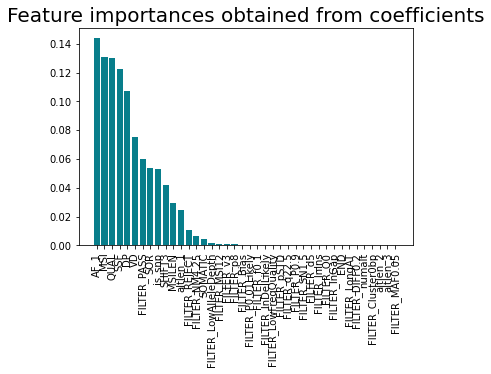

In [ ]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, stratify = y)
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    print(y_train.value_counts().to_dict())
    print(y_test.value_counts().to_dict())
    return(X_train, X_test, y_train, y_test)

In [ ]:
clf = RandomForestClassifier(random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = split_data(X, y)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

(3561102, 40)
(1187035, 40)
(3561102,)
(1187035,)
{0: 3560218, 1: 884}
{0: 1186740, 1: 295}
0.7038834951456311
0.4915254237288136
0.5788423153692616


In [ ]:
clf = SVC()

## Validation

In [ ]:
val_results = {}
for file in validation_sets:
    df = p_data[file]
    X_test, y_test = df[features], df[target]
    y_pred = clf.predict(X_test)
    val_results[file] = {}
    val_results[file]['Precision'] = precision_score(y_test, y_pred)
    val_results[file]['Recall'] = recall_score(y_test, y_pred)
    val_results[file]['F1 Score'] = f1_score(y_test, y_pred)
val_results

{'real2': {'F1 Score': 0.0, 'Precision': 0.0, 'Recall': 0.0}}

## Get Predictions

In [ ]:
for clf in clf_data.keys():
  for file in test_sets:
      df = p_data[file]
      X_test = df[features]
      y_pred = clf_data[clf].predict(X_test)
      df['y_pred'] = y_pred
      res_df = df.copy()
      res_df = res_df[res_df['y_pred'] == 1]
      res_df.drop(['FILTER_PASS_freebayes', 'FILTER_PASS_mutect2', 'FILTER_PASS_vardict', 'FILTER_PASS_varscan', 'y_pred'], axis=1, inplace = True)
      res_df.columns = ['CHROM', 'START_POS']
      res_df['END_POS'] = res_df['START_POS']
      res_df.to_csv(HOME+'/'+file+'_'+clf+'_test.bed', sep='\t')